In [6]:
import os

import numpy as np
import pandas as pd

# Wheat Images

In [88]:
from PIL import Image
from utils.thumb_grid import thumb_grid
import matplotlib.pyplot as plt

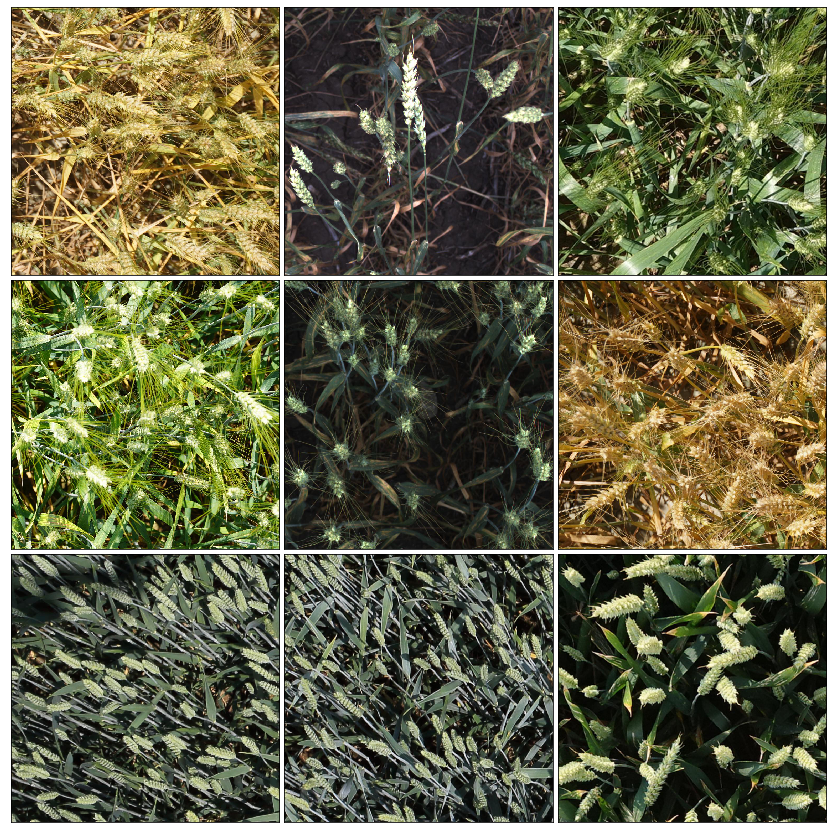

In [160]:
img_ids = os.listdir("data/train")

grid_ids = np.random.choice(img_ids, 9)
grid_imgs = []
for grid_id in grid_ids:
    grid_imgs.append(np.array(Image.open("data/train/" + grid_id)))

plt.figure(figsize = (15, 15))
thumb_grid(grid_imgs, (3, 3), scale = 1)

# Bounding Boxes

In [110]:
from PIL import ImageDraw
import re

In [131]:
# Clean bounding boxes dataset

bboxes = pd.read_csv("data/train.csv")

bboxes.bbox = bboxes.apply(lambda boxes: [int(float(i)) for i in boxes['bbox'].strip('][').split(', ')]  , axis = 1)

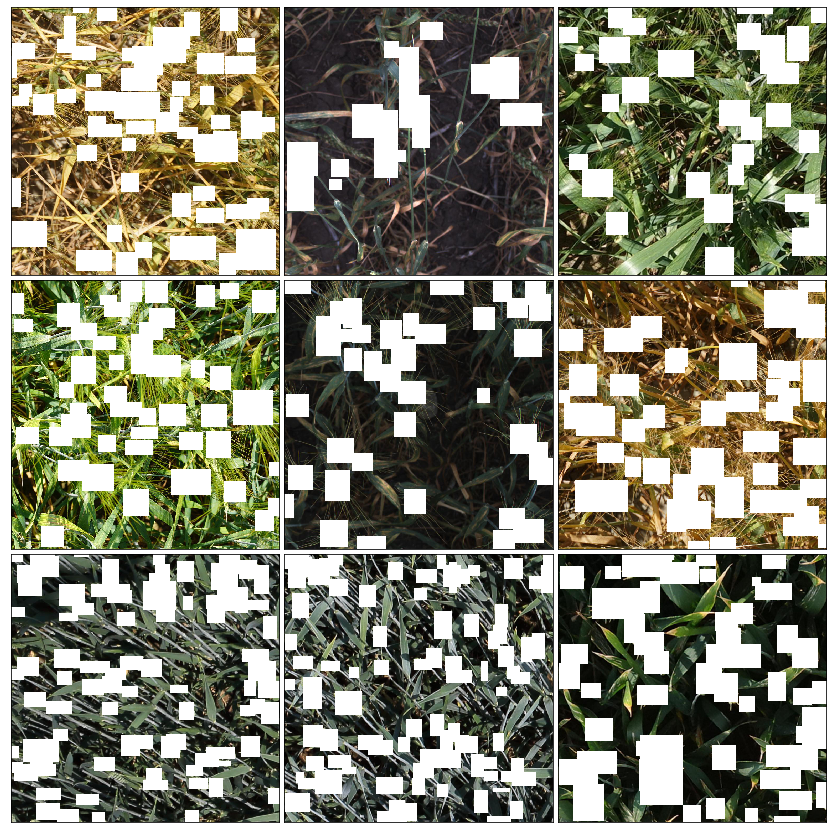

In [161]:
# grid_ids = np.random.choice(img_ids, 9)
grid_imgs = []

for grid_id in grid_ids:
    
    img = Image.open("data/train/" + grid_id)
    
    grid_id = re.sub(".jpg", "", grid_id)
    bbox = bboxes[bboxes.image_id == grid_id]
    
    draw = ImageDraw.Draw(img)
    
    for coords in bbox.bbox:
        draw.rectangle((coords[0], coords[1], coords[0] + coords[2], coords[1] + coords[3]), 
                       fill = "white",
                      outline = "white")
    
    grid_imgs.append(np.array(img))

plt.figure(figsize = (15, 15))
thumb_grid(grid_imgs, (3, 3), scale = 1)

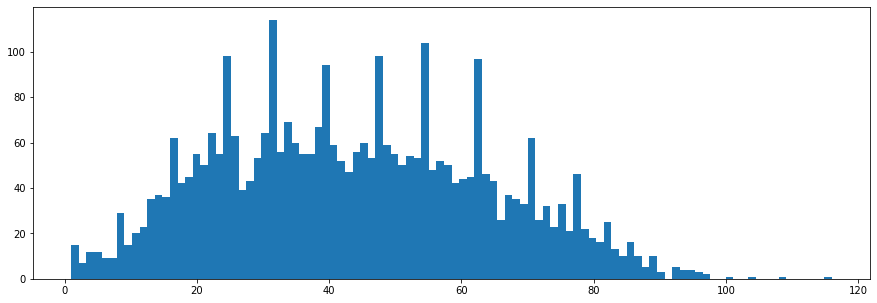

In [178]:
# Number of wheat heads per image

plt.figure(figsize = (15, 5))
plt.hist(bboxes.groupby(['image_id']).agg(['count']).iloc[:, 0], bins = 100);

# Segmentation Using PyTorch

In [ ]:
import torch

class WheatDataset(object):
    
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "data", "train"))))
#         self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx, bbox):
        # load images ad masks
        img_path = os.path.join(self.root, "data", "train", self.imgs[idx])
#         mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
#         mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
#         mask = np.array(mask)
        # instances are encoded as different colors
#         obj_ids = np.unique(mask)
        # first id is the background, so remove it
#         obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
#         masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = bbox.shape[0]
        
        boxes = []
        for i in range(num_objs):
#             pos = np.where(masks[i])
#             xmin = np.min(pos[1])
#             xmax = np.max(pos[1])
#             ymin = np.min(pos[0])
#             ymax = np.max(pos[0])
            boxes.append(bbox.bbox)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
#         masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not wheat
        iswheat = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)